In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
EPOCHS = 1000

In [3]:
tf.__version__

'1.13.1'

## MPG Dataset

Get the dataset

In [4]:
dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)
dataset_path

'/home/ec2-user/.keras/datasets/auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, comment="\t", na_values="?", names=column_names, sep=" ", skipinitialspace=True)

# make a copy
dataset = raw_dataset.copy()
dataset.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
42,12.0,8,383.0,180.0,4955.0,11.5,71,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,1
241,22.0,6,146.0,97.0,2815.0,14.5,77,3
87,13.0,8,350.0,145.0,3988.0,13.0,73,1
134,16.0,6,258.0,110.0,3632.0,18.0,74,1


### Cleaning Dataset

Remove NA values.

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [8]:
# convert origin to one-hot attributes
origin = dataset.pop('Origin')
origin.sample(5)

68     1
40     1
358    3
55     2
66     1
Name: Origin, dtype: int64

In [9]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
287,16.5,8,351.0,138.0,3955.0,13.2,79,1.0,0.0,0.0
7,14.0,8,440.0,215.0,4312.0,8.5,70,1.0,0.0,0.0
391,36.0,4,135.0,84.0,2370.0,13.0,82,1.0,0.0,0.0
242,21.5,4,121.0,110.0,2600.0,12.8,77,0.0,1.0,0.0
277,16.2,6,163.0,133.0,3410.0,15.8,78,0.0,1.0,0.0


### Split Data

Need training and testing data sets.

In [10]:
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)

### Inspect Data

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


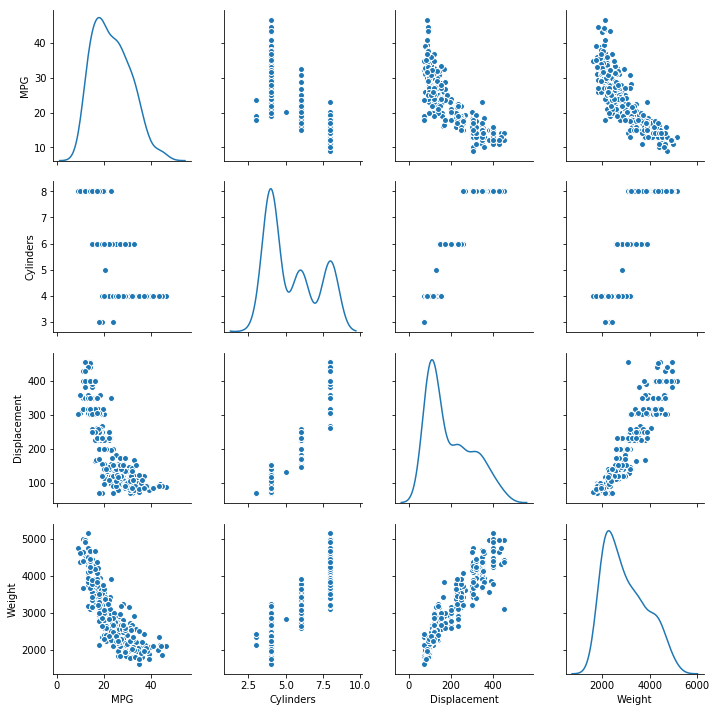

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [12]:
train_stats = train_dataset.describe()
train_stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.309236,5.452229,194.671975,105.296178,2985.296178,15.533439,75.885350,0.633758,0.156051,0.210191
std,7.835082,1.693611,105.821074,40.034069,865.964633,2.777189,3.605938,0.482546,0.363483,0.408095
min,9.000000,3.000000,70.000000,46.000000,1613.000000,8.500000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,104.250000,75.000000,2228.500000,13.700000,73.000000,0.000000,0.000000,0.000000
50%,22.450000,4.000000,148.500000,93.500000,2781.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,29.000000,8.000000,265.250000,129.000000,3618.250000,17.175000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [13]:
# keep track of transposed train_stats to normalize
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.309236,7.835082,9.0,17.00,22.45,29.000,46.6
Cylinders,314.0,5.452229,1.693611,3.0,4.00,4.00,8.000,8.0
Displacement,314.0,194.671975,105.821074,70.0,104.25,148.50,265.250,455.0
Horsepower,314.0,105.296178,40.034069,46.0,75.00,93.50,129.000,230.0
Weight,314.0,2985.296178,865.964633,1613.0,2228.50,2781.50,3618.250,5140.0
Acceleration,314.0,15.533439,2.777189,8.5,13.70,15.50,17.175,24.8
Model Year,314.0,75.885350,3.605938,70.0,73.00,76.00,79.000,82.0
USA,314.0,0.633758,0.482546,0.0,0.00,1.00,1.000,1.0
Europe,314.0,0.156051,0.363483,0.0,0.00,0.00,0.000,1.0
Japan,314.0,0.210191,0.408095,0.0,0.00,0.00,0.000,1.0


### Isolate Labels

Separate labels (the target values) from the data.

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize Data

In [15]:
def normalize(df):
    return (df - train_stats['mean']) / train_stats['std']

In [16]:
normed_train_dataset = normalize(train_dataset)
normed_test_dataset = normalize(test_dataset)

normed_train_dataset.pop("MPG")
normed_test_dataset.pop("MPG")

normed_train_dataset.sample(5)

,Acceleration,Cylinders,Displacement,Europe,Horsepower,Japan,Model Year,USA,Weight
342,-0.948239,-0.857475,-0.563895,-0.429321,-0.531951,-0.515055,1.418397,0.758979,-0.693211
307,-0.948239,0.323434,-0.204798,-0.429321,0.242389,-0.515055,0.863756,0.758979,-0.329455
353,-0.480140,-0.857475,-0.847392,2.321840,-0.781739,-0.515055,1.418397,-1.313364,-0.918393
277,0.095982,0.323434,-0.299297,2.321840,0.692006,-0.515055,0.586435,-1.313364,0.490440
155,1.428265,0.323434,0.522845,-0.429321,-0.831696,-0.515055,-0.245526,0.758979,0.199435


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


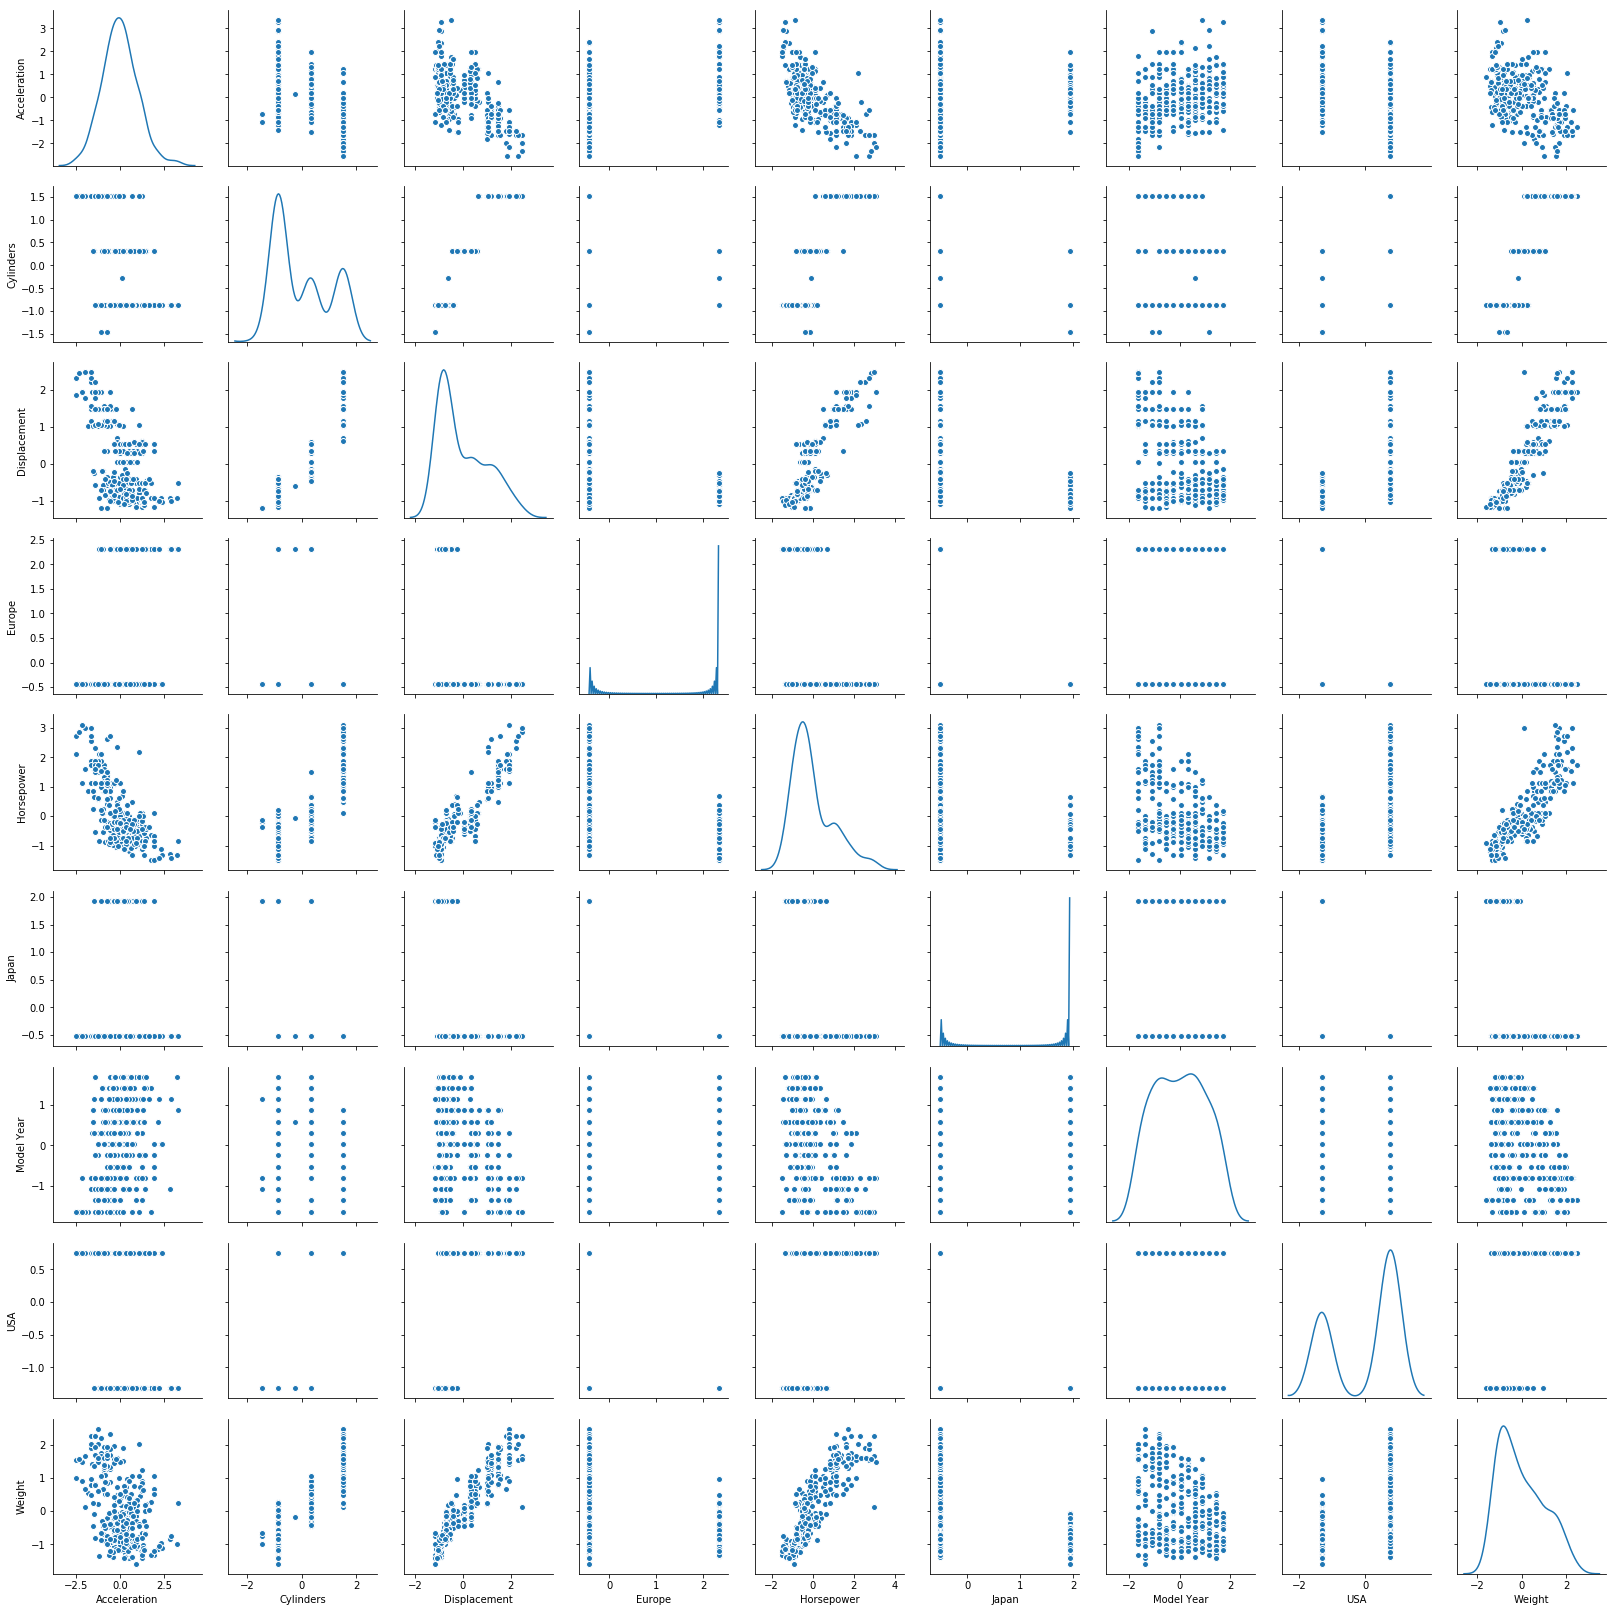

In [17]:
sns.pairplot(normed_train_dataset, diag_kind='kde')

## The Model

In [18]:
# wrap model creation in function
def build_model():
    
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    model.compile(
        loss='mse',
        metrics=['mae', 'mse'],
        optimizer=optimizer
    )
    
    return model

In [19]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Inspect Model

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [21]:
# try model on tiny input
example_batch = normed_train_dataset.sample(10)
example_result = model.predict(example_batch)
example_result

array([[-0.08616203],
       [-0.2093268 ],
       [-0.11147445],
       [ 0.06361984],
       [-0.06918719],
       [ 0.07865107],
       [-0.14818993],
       [ 0.09725617],
       [ 0.04333761],
       [-0.25546134]], dtype=float32)

### Train Model

In [22]:
# callback subclass for feedback
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if (epoch % 100 == 0):
            print('')
        print('.', end="")

In [23]:
# track history for inspection later
history = model.fit(normed_train_dataset, train_labels, callbacks=[PrintDot()], epochs=EPOCHS, validation_split=0.2, verbose=0)

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [24]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch
hist_df.sample(5).sort_values(by='epoch')

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
653,2.605571,1.161595,2.605572,7.765942,1.962835,7.765942,653
657,2.532404,1.121342,2.532404,10.212004,2.248628,10.212003,657
739,2.505209,1.159174,2.505208,10.475088,2.327164,10.475088,739
813,2.193531,1.030486,2.193531,12.401709,2.514344,12.401710,813
819,2.165049,1.022193,2.165049,8.565347,2.025057,8.565348,819


In [25]:
def plot_history(history, hist_df):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error [MPG]")
    plt.plot(hist_df['epoch'], hist_df['mean_absolute_error'], label="Train Error")
    plt.plot(hist_df['epoch'], hist_df['val_mean_absolute_error'], label="Validation Error")
    plt.legend()
    plt.ylim([0, 5])
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$MPG^2$]")
    plt.plot(hist_df['epoch'], hist_df['mean_squared_error'], label="Train Error")
    plt.plot(hist_df['epoch'], hist_df['val_mean_squared_error'], label="Validation Error")
    plt.legend()
    plt.ylim([0, 20])

Plot history and note the diminishing returns.

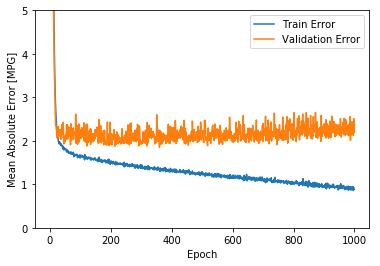

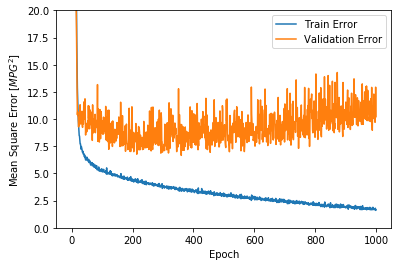

In [26]:
plot_history(history, hist_df)

In [27]:
# use a callback to do early stopping for better results
model = build_model()

early_stop_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

history = model.fit(normed_train_dataset, train_labels, callbacks=[early_stop_cb, PrintDot()], epochs=EPOCHS, validation_split=0.2,
    verbose=0)


....................................................................................................
..............................

In [29]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch
hist_df.sample(5).sort_values(by='epoch')

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
6,287.227060,15.646276,287.227051,213.925646,13.809334,213.925659,6
39,6.735693,1.908153,6.735694,8.519578,2.017759,8.519578,39
81,5.479129,1.726947,5.479130,8.106213,2.083309,8.106213,81
87,5.303214,1.688326,5.303215,6.409147,1.825776,6.409147,87
101,5.363073,1.659845,5.363073,8.693975,2.187080,8.693974,101


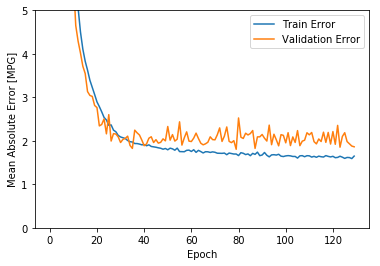

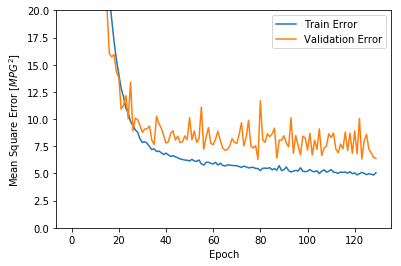

In [30]:
plot_history(history, hist_df)

Test model against test data.

In [31]:
loss, mae, mse = model.evaluate(normed_test_dataset, test_labels, verbose=0)

In [32]:
print("Testing MAE: {:5.2f}".format(mae))

Testing MAE:  2.03


### Make Predictions

In [33]:
test_predictions = model.predict(normed_test_dataset).flatten()

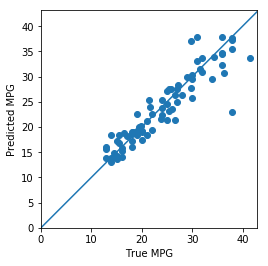

In [34]:
plt.scatter(test_labels, test_predictions)
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

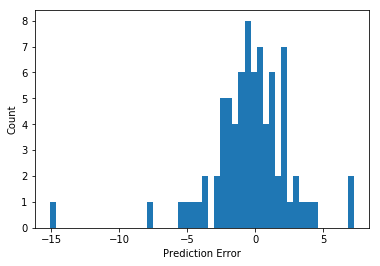

In [35]:
error = test_predictions - test_labels
plt.hist(error, bins=50)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
_ = plt.plot()